In [135]:
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)
from scipy.stats import mode
import swifter

In [136]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')
df_hist_trans = pd.read_csv('../input/historical_transactions.csv')
df_new_merchant_trans = pd.read_csv('../input/new_merchant_transactions.csv')

In [137]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['category_2'].fillna(1.0,inplace=True)
    df['category_3'].fillna('A',inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)


In [138]:
df_hist_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [139]:
pd.set_option('display.max_columns', None)

In [140]:
df_merchants = pd.read_csv("../input/merchants.csv").drop_duplicates(subset='merchant_id', keep="last")

In [141]:
df_merchants.head(5)

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,9.666667,3,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,1.750000,3,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,260.000000,2,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,1.666667,3,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,0.500000,3,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [142]:
cols_to_use = df_merchants.columns.difference(df_hist_trans.columns).tolist() + ["merchant_id"]

In [143]:
df_merchants[cols_to_use].head(5)

,active_months_lag12,active_months_lag3,active_months_lag6,avg_purchases_lag12,avg_purchases_lag3,avg_purchases_lag6,avg_sales_lag12,avg_sales_lag3,avg_sales_lag6,category_4,merchant_group_id,most_recent_purchases_range,most_recent_sales_range,numerical_1,numerical_2,merchant_id
0,12,3,6,13.916667,9.666667,18.666667,-2.32,-0.40,-2.25,N,8353,E,E,-0.057471,-0.057471,M_ID_838061e48c
1,12,3,6,1.687500,1.750000,1.291667,-0.57,-0.72,-0.74,N,3184,E,E,-0.057471,-0.057471,M_ID_9339d880ad
2,2,2,2,260.000000,260.000000,260.000000,-82.13,-82.13,-82.13,N,447,E,E,-0.057471,-0.057471,M_ID_e726bbae1e
3,12,3,6,3.833333,1.666667,4.666667,NaN,NaN,NaN,Y,5026,E,E,-0.057471,-0.057471,M_ID_a70e9c5f81
4,12,3,6,0.347222,0.500000,0.361111,NaN,NaN,NaN,Y,2228,E,E,-0.057471,-0.057471,M_ID_64456c37ce


In [144]:
df_hist_trans = df_hist_trans.merge(df_merchants[cols_to_use],on="merchant_id",how="left")

In [145]:
df_new_merchant_trans = df_new_merchant_trans.merge(df_merchants[cols_to_use],on="merchant_id",how="left")

In [146]:
df_hist_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,active_months_lag12,active_months_lag3,active_months_lag6,avg_purchases_lag12,avg_purchases_lag3,avg_purchases_lag6,avg_sales_lag12,avg_sales_lag3,avg_sales_lag6,category_4,merchant_group_id,most_recent_purchases_range,most_recent_sales_range,numerical_1,numerical_2
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,12,3,6,1.156844,1.082451,1.114135,1.19,1.08,1.14,Y,35,A,A,23.470597,23.014512
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,12,3,6,1.062087,1.052071,1.058605,1.05,1.06,1.06,Y,2084,A,A,1.092658,-0.057471
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,12,3,6,0.956668,0.974653,0.967058,0.97,0.98,0.98,Y,27369,C,C,0.021849,0.021849
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34,12,3,6,0.864394,1.053443,0.897406,0.86,1.00,0.88,Y,24104,C,D,-0.057471,-0.057471
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37,12,3,6,1.156844,1.082451,1.114135,1.19,1.08,1.14,Y,35,A,A,23.470597,23.014512


In [147]:
agg = {
    "numerical_1":['sum','max','min','mean','var'],
    "numerical_2":['sum','max','min','mean','var'],
    "category_1":{"mode" : lambda x : pd.Series.mode(x)[0]},
    "most_recent_sales_range":{"mode" : lambda x : pd.Series.mode(x)[0]},
    "most_recent_purchases_range":{"mode" : lambda x : pd.Series.mode(x)[0]},
    "avg_sales_lag3":['sum','max','min','mean','var'],
    "avg_purchases_lag3":['sum','max','min','mean','var'],
    "active_months_lag3":['sum','max','min','mean','var'],
    "avg_sales_lag6":['sum','max','min','mean','var'],
    "avg_purchases_lag6":['sum','max','min','mean','var'],
    "active_months_lag6":['sum','max','min','mean','var'],
    "avg_sales_lag12":['sum','max','min','mean','var'],    
    "avg_purchases_lag12":['sum','max','min','mean','var'],    
    "active_months_lag12":['sum','max','min','mean','var'],
    "category_4":{"mode" : lambda x : pd.Series.mode(x)},
    "category_2":{"mode" : lambda x : pd.Series.mode(x)},
    }

In [148]:
len(df_hist_trans.columns.tolist())

29

In [149]:
holidays = np.asarray([np.datetime64(date) for date in ['2017-01-01','2017-02-27','2017-02-28','2017-03-01','2017-04-14','2017-04-16','2017-04-21','2017-05-01','2017-06-15','2017-09-07','2017-10-12','2017-11-02','2017-11-15','2017-12-25','2018-01-01','2018-02-12','2018-02-13','2018-03-30','2018-04-21','2018-05-01','2018-05-31','2018-09-07','2018-10-12','2018-11-02','2018-11-15','2018-11-20','2018-12-25']])
seasons = [0,0,0,1,1,1,2,2,2,4,4,4]

def closest_holiday_days(x):
    deltas = holidays - np.datetime64(x)
    vect_abs = np.vectorize(abs)
    vect_days = np.vectorize(lambda x: x)
    absed = vect_abs(vect_days(deltas))
    return min(absed).item().days

In [150]:
def is_in_business_hours(x):
    if (x >= 9) and (x <= 20 ):
        return 1
    else:
        return 0   

def is_close_to_pay_day(x):
    if (x > 27) or (x < 4):
        return 1
    else:
        return 0

from math import ceil

def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    """

    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))    

In [151]:
is_close_to_pay_day(28)

1

In [152]:
%timeit closest_holiday_days(datetime.datetime.today())

252 µs ± 4.03 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [153]:
import dask.dataframe as dd

# df_hist_trans = df_hist_trans.head(10000)
# df_new_merchant_trans = df_new_merchant_trans.head(10000)

tqdm.pandas()


for df in [df_hist_trans,df_new_merchant_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])    
    print("processsed purchase_date")
    df['year'] = df['purchase_date'].dt.year
    print("year") 
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    print("wof")     
    df['month'] = df['purchase_date'].dt.month
    print("month")         
    df['season'] = df['month'].swifter.progress_bar(True).apply(lambda x:seasons[x-1])
    print("season")    
    df['closest_date_to_holiday'] = df['purchase_date'].swifter.progress_bar(True).apply(closest_holiday_days)
    print("holiday")             
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    print("dayofweek")    
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    print("weekend")        
    df['hour'] = df['purchase_date'].dt.hour
    print("hour")    
    df['weekofmonth'] = df['purchase_date'].swifter.progress_bar(True).apply(week_of_month)
    print('weekofmonth')    
#     df['is_in_business_hours'] = df['hour'].progress_apply(is_in_business_hours)
#     print('is_in_business_hours')
#     df['is_close_to_pay_day'] = df['month'].progress_apply(is_close_to_pay_day)
#     print('is_close_to_pay_day')    
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    print("AF")            
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    print("cat_1")    
    #https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73244
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    print("month_diff")                
    df['month_diff'] += df['month_lag']

processsed purchase_date
year
wof
month



season



holiday
dayofweek
weekend
hour



weekofmonth
AF
cat_1
month_diff
processsed purchase_date
year
wof
month



season



holiday
dayofweek
weekend
hour



weekofmonth
AF
cat_1
month_diff


In [154]:
pd.set_option('display.width', -1)

In [155]:
df_hist_trans.head(5)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,active_months_lag12,active_months_lag3,active_months_lag6,avg_purchases_lag12,avg_purchases_lag3,avg_purchases_lag6,avg_sales_lag12,avg_sales_lag3,avg_sales_lag6,category_4,merchant_group_id,most_recent_purchases_range,most_recent_sales_range,numerical_1,numerical_2,year,weekofyear,month,season,closest_date_to_holiday,dayofweek,weekend,hour,weekofmonth,month_diff
0,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,12,3,6,1.156844,1.082451,1.114135,1.19,1.08,1.14,Y,35,A,A,23.470597,23.014512,2017,25,6,1,10,6,1,15,4,10
1,1,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,12,3,6,1.062087,1.052071,1.058605,1.05,1.06,1.06,Y,2084,A,A,1.092658,-0.057471,2017,28,7,2,30,5,1,12,3,10
2,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,12,3,6,0.956668,0.974653,0.967058,0.97,0.98,0.98,Y,27369,C,C,0.021849,0.021849,2017,32,8,2,28,2,0,22,2,10
3,1,C_ID_4e6213e9bc,88,0,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34,12,3,6,0.864394,1.053443,0.897406,0.86,1.00,0.88,Y,24104,C,D,-0.057471,-0.057471,2017,35,9,2,4,5,1,10,1,10
4,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37,12,3,6,1.156844,1.082451,1.114135,1.19,1.08,1.14,Y,35,A,A,23.470597,23.014512,2017,10,3,0,9,4,0,1,2,10


In [156]:
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [157]:
def write_df_hist():
    df_hist_trans.to_csv("df_hist_trans.csv")

def new_merchant_trans():
    df_new_merchant_trans.to_csv("df_new_merchant_trans.csv")

In [158]:
from multiprocessing import Process
p = Process(target=write_df_hist)
p.start()

# df_hist_trans.to_csv("df_hist_trans.csv")
# df_new_merchant_trans.to_csv("df_new_merchant_trans.csv")

In [159]:
from multiprocessing import Process
p = Process(target=new_merchant_trans)
p.start()

In [160]:
# df_hist_trans = pd.read_csv("df_hist_trans.csv")

# df_new_merchant_trans = pd.read_csv("df_new_merchant_trans.csv")

In [161]:
# df_train = pd.read_csv('../input/train.csv')
# df_test = pd.read_csv('../input/test.csv')


In [162]:
pd.set_option('display.width', -1)

In [163]:
df_hist_trans['purchase_date'] = pd.to_datetime(df_hist_trans['purchase_date'])    
df_new_merchant_trans['purchase_date'] = pd.to_datetime(df_new_merchant_trans['purchase_date'])    

In [164]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id','city_id','state_id']:
    aggs[col] = ['nunique']


aggs['avg_sales_lag3'] = ['sum','max','min','mean','var']
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['season'] = ['sum','max','min','mean','var']
# aggs['is_in_business_hours'] = ['sum','max','min','mean','var']
# aggs['is_close_to_pay_day'] = ['sum','max','min','mean','var']
aggs["avg_sales_lag6"] = ['sum','max','min','mean','var']
aggs['weekofmonth'] = ['sum','max','min','mean','var']
aggs['closest_date_to_holiday'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_hist_trans[col+'_mean'] = df_hist_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']    

new_columns = get_new_columns('hist',aggs)
df_hist_trans_group = df_hist_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['hist_purchase_date_diff'] = (df_hist_trans_group['hist_purchase_date_max'] - df_hist_trans_group['hist_purchase_date_min']).dt.days
df_hist_trans_group['hist_purchase_date_average'] = df_hist_trans_group['hist_purchase_date_diff']/df_hist_trans_group['hist_card_id_size']
df_hist_trans_group['hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

112

In [165]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id','city_id','state_id']:
    aggs[col] = ['nunique']

aggs['avg_sales_lag3'] = ['sum','max','min','mean','var']    
aggs["avg_sales_lag6"] = ['sum','max','min','mean','var']
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['season'] = ['sum','max','min','mean','var']
# aggs['is_in_business_hours'] = ['sum','max','min','mean','var']
# aggs['is_close_to_pay_day'] = ['sum','max','min','mean','var']
aggs['weekofmonth'] = ['sum','max','min','mean','var']
aggs['closest_date_to_holiday'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_new_merchant_trans[col+'_mean'] = df_new_merchant_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']
    
new_columns = get_new_columns('new_hist',aggs)
df_hist_trans_group = df_new_merchant_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['new_hist_purchase_date_diff'] = (df_hist_trans_group['new_hist_purchase_date_max'] - df_hist_trans_group['new_hist_purchase_date_min']).dt.days
df_hist_trans_group['new_hist_purchase_date_average'] = df_hist_trans_group['new_hist_purchase_date_diff']/df_hist_trans_group['new_hist_card_id_size']
df_hist_trans_group['new_hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['new_hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

42

In [166]:
del df_hist_trans;gc.collect()
del df_new_merchant_trans;gc.collect()
df_train.head(5)


,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,hist_year_nunique,hist_subsector_id_nunique,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_city_id_nunique,hist_state_id_nunique,hist_avg_sales_lag3_sum,hist_avg_sales_lag3_max,hist_avg_sales_lag3_min,hist_avg_sales_lag3_mean,hist_avg_sales_lag3_var,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_var,hist_installments_sum,hist_installments_max,hist_installments_min,hist_installments_mean,hist_installments_var,hist_season_sum,hist_season_max,hist_season_min,hist_season_mean,hist_season_var,hist_avg_sales_lag6_sum,hist_avg_sales_lag6_max,hist_avg_sales_lag6_min,hist_avg_sales_lag6_mean,hist_avg_sales_lag6_var,hist_weekofmonth_sum,hist_weekofmonth_max,hist_weekofmonth_min,hist_weekofmonth_mean,hist_weekofmonth_var,hist_closest_date_to_holiday_sum,hist_closest_date_to_holiday_max,hist_closest_date_to_holiday_min,hist_closest_date_to_holiday_mean,hist_closest_date_to_holiday_var,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_max,hist_month_lag_min,hist_month_lag_mean,hist_month_lag_var,hist_month_diff_mean,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_weekend_sum,hist_weekend_mean,hist_category_1_sum,hist_category_1_mean,hist_card_id_size,hist_category_2_mean_mean,hist_category_3_mean_mean,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow,new_hist_month_nunique,new_hist_hour_nunique,new_hist_weekofyear_nunique,new_hist_dayofweek_nunique,new_hist_year_nunique,new_hist_subsector_id_nunique,new_hist_merchant_id_nunique,new_hist_merchant_category_id_nunique,new_hist_city_id_nunique,new_hist_state_id_nunique,new_hist_avg_sales_lag3_sum,new_hist_avg_sales_lag3_max,new_hist_avg_sales_lag3_min,new_hist_avg_sales_lag3_mean,new_hist_avg_sales_lag3_var,new_hist_avg_sales_lag6_sum,new_hist_avg_sales_lag6_max,new_hist_avg_sales_lag6_min,new_hist_avg_sales_lag6_mean,new_hist_avg_sales_lag6_var,new_hist_purchase_amount_sum,new_hist_purchase_amount_max,new_hist_purchase_amount_min,new_hist_purchase_amount_mean,new_hist_purchase_amount_var,new_hist_installments_sum,new_hist_installments_max,new_hist_installments_min,new_hist_installments_mean,new_hist_installments_var,new_hist_season_sum,new_hist_season_max,new_hist_season_min,new_hist_season_mean,new_hist_season_var,new_hist_weekofmonth_sum,new_hist_weekofmonth_max,new_hist_weekofmonth_min,new_hist_weekofmonth_mean,new_hist_weekofmonth_var,new_hist_closest_date_to_holiday_sum,new_hist_closest_date_to_holiday_max,new_hist_closest_date_to_holiday_min,new_hist_closest_date_to_holiday_mean,new_hist_closest_date_to_holiday_var,new_hist_purchase_date_max,new_hist_purchase_date_min,new_hist_month_lag_max,new_hist_month_lag_min,new_hist_month_lag_mean,new_hist_month_lag_var,new_hist_month_diff_mean,new_hist_weekend_sum,new_hist_weekend_mean,new_hist_category_1_sum,new_hist_category_1_mean,new_hist_card_id_size,new_hist_category_2_mean_mean,new_hist_category_3_mean_mean,new_hist_purchase_date_diff,new_hist_purchase_date_average,new_hist_purchase_date_uptonow
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,9,23,35,7,2,21,94,41,7,3,297.40,7.73,0.71,1.143846,0.512173,-165.968739,2.258395,-0.739395,-0.638341,0.045003,4,1,0,0.015385,0.015206,629,4,0,2.419231,2.059088,1841.73,147.69,0.58,7.083577,845.810161,801,6,1,3.080769,1.665266,3577,41,0,13.757692,120.578126,2018-02-25 09:31:15,2017-06-27 14:18:08,0,-8,-3.911538,5.748901,9.788462,247,0.950000,90,0.346154,0,0.000000,260,0.072502,0.346719,242,0.930769,297,2.0,8.0,7.0,7.0,1.0,10.0,23.0,14.0,3.0,1.0,25.31,2.99,0.68,1.100435,0.180577,25.02,3.11,0.65,1.087826,0.215600,-13.244202,-0.296112,-0.724368,-0.575835,0.018445,0.0,0.0,0.0,0.000000,0.000000,11.0,1.0,0.0,0.478261,0.260870,78.0,5.0,2.0,3.391304,1.612648,181.0,21.0,0.0,7.869565,53.573123,2018-04-29 11:23:05,2018-03-05 14:04:36,2.

In [167]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [168]:
for df in [df_train,df_test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']

for f in ['feature_1','feature_2','feature_3']:
    order_label = df_train.groupby([f])['outliers'].mean()
    df_train[f] = df_train[f].map(order_label)
    df_test[f] = df_test[f].map(order_label)


In [169]:
def write_df_train():
    df_train.to_csv("elo_train.csv")

from multiprocessing import Process
p = Process(target=write_df_train)
p.start()

In [170]:
def write_df_test():
    df_test.to_csv("elo_test.csv")

from multiprocessing import Process
p = Process(target=write_df_test)
p.start()

In [171]:
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','target','outliers']]
target = df_train['target']
del df_train['target']

In [172]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.72979	valid_1's rmse: 3.76599
[200]	training's rmse: 3.66181	valid_1's rmse: 3.72121
[300]	training's rmse: 3.61536	valid_1's rmse: 3.69902
[400]	training's rmse: 3.5805	valid_1's rmse: 3.68671
[500]	training's rmse: 3.55374	valid_1's rmse: 3.6791
[600]	training's rmse: 3.53075	valid_1's rmse: 3.67392
[700]	training's rmse: 3.5104	valid_1's rmse: 3.66936
[800]	training's rmse: 3.49161	valid_1's rmse: 3.66526
[900]	training's rmse: 3.47532	valid_1's rmse: 3.66242
[1000]	training's rmse: 3.46034	valid_1's rmse: 3.66011
[1100]	training's rmse: 3.44612	valid_1's rmse: 3.65839
[1200]	training's rmse: 3.43265	valid_1's rmse: 3.65712
[1300]	training's rmse: 3.42038	valid_1's rmse: 3.65581
[1400]	training's rmse: 3.40885	valid_1's rmse: 3.65455
[1500]	training's rmse: 3.3978	valid_1's rmse: 3.65344
[1600]	training's rmse: 3.38708	valid_1's rmse: 3.65252
[1700]	training's rmse: 3.37624	valid_1's rmse:

3.6529339893770905

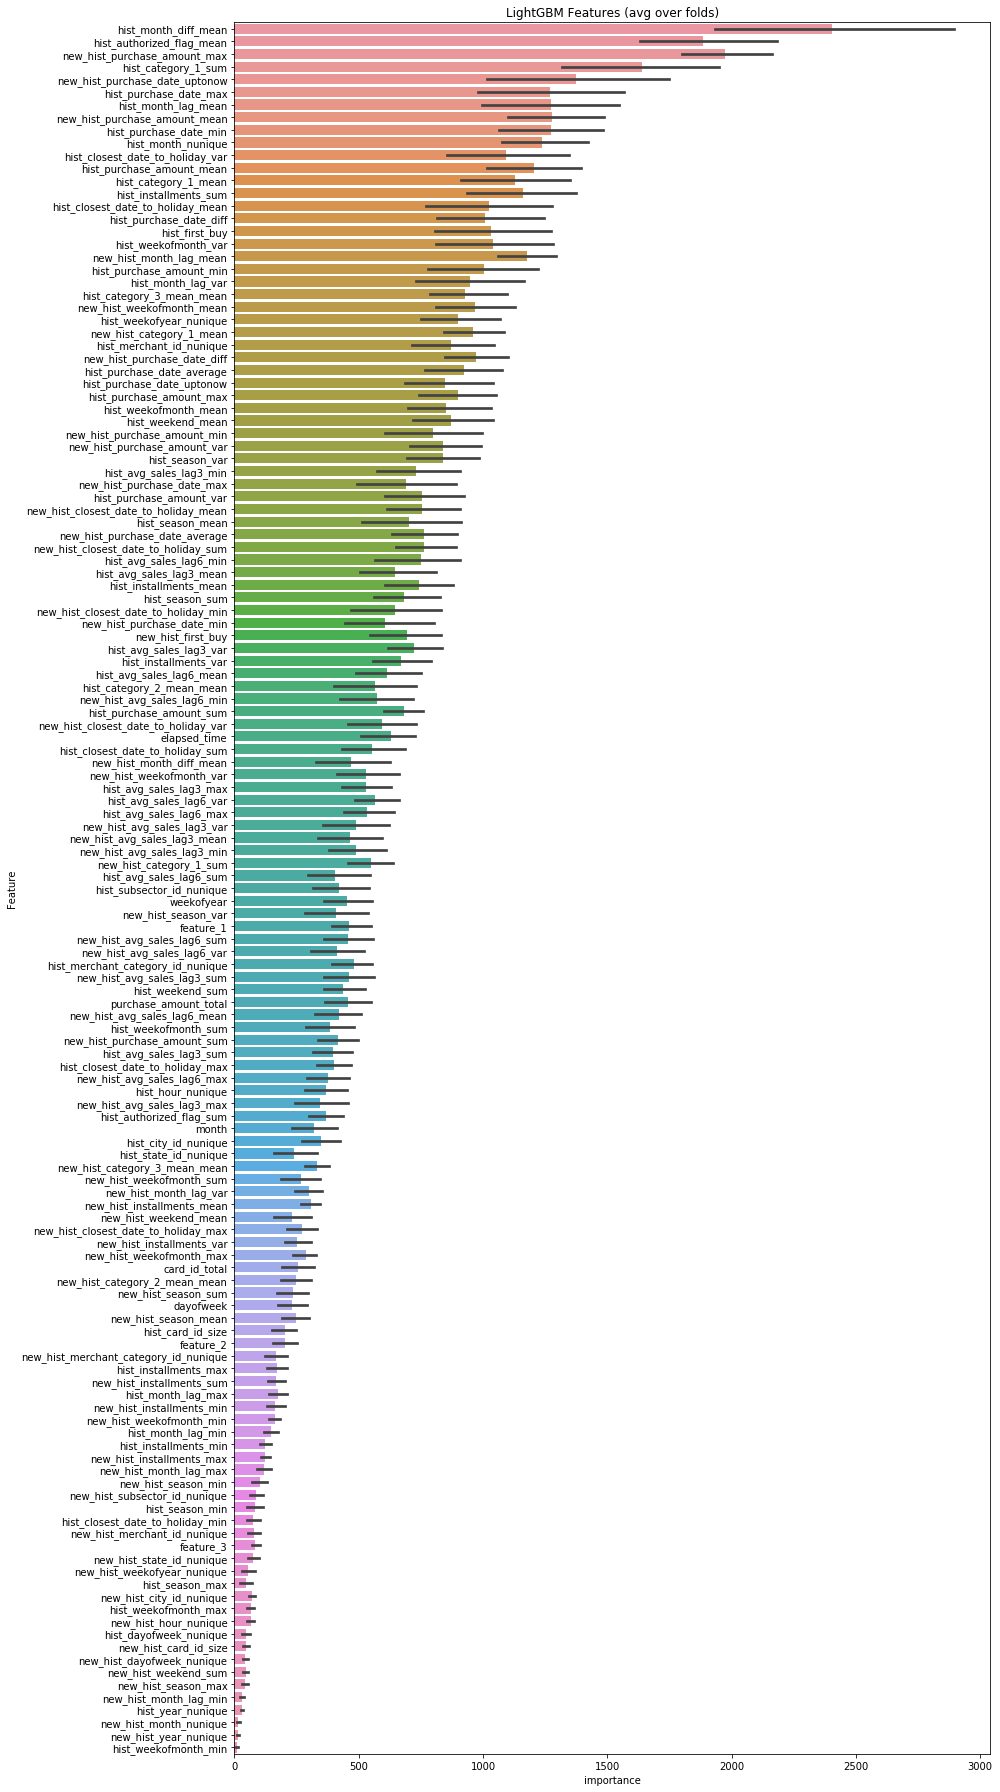

In [173]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')


In [174]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submission_avg_sales_lag_6.csv", index=False)

In [11]:
pd.set_option('display.max_columns', None)

In [178]:
from scipy import stats

In [92]:
best_features.sort_values(by="importance",ascending=False).head(100)

,Feature,importance,fold
49,hist_month_diff_mean,3112,2
78,new_hist_purchase_amount_max,2473,2
51,hist_authorized_flag_mean,2407,2
49,hist_month_diff_mean,2374,1
49,hist_month_diff_mean,2353,3
54,hist_category_1_sum,2184,2
49,hist_month_diff_mean,2182,4
78,new_hist_purchase_amount_max,2137,3
118,new_hist_purchase_date_uptonow,2038,2
51,hist_authorized_flag_mean,1999,3


In [226]:
len(a)

60

In [171]:
mode([1,3,2,3,5])[0][0]

3

In [ ]:
# holidays = [1,3,2,3,5]
print(holidays)
a = [date for date in holidays]

In [ ]:
min(df_new_merchant_trans["purchase_date"])

In [ ]:
max(df_new_merchant_trans["purchase_date"])

In [ ]:
df_new_merchant_trans.dtypes

In [ ]:
[pd.to_datetime(date) for date in ["Jan 01, 2017","Feb 27, 2017","Feb 28, 2017","Mar 01, 2017","Apr 14, 2017","Apr 16, 2017","Apr 21, 2017","May 01, 2017","Jun 15, 2017","Sep 07, 2017","Oct 12, 2017","Nov 02, 2017","Nov 15, 2017","Dec 25, 2017","1 Jan 2018","12 Feb 2018","13 Feb 2018","30 Mar 2018","21 Apr 2018","1 May 2018","31 May 2018","7 Sep 2018","12 Oct 2018","2 Nov 2018","15 Nov 2018","20 Nov 2018","25 Dec 2018"]]

In [ ]:
(pd.to_datetime("Apr 21, 2017") - pd.to_datetime('2017-01-01 00:00:08')).days

In [29]:
holidays = np.asarray([pd.to_datetime(date) for date in ["Jan 01, 2017","Feb 27, 2017","Feb 28, 2017","Mar 01, 2017","Apr 14, 2017","Apr 16, 2017","Apr 21, 2017","May 01, 2017","Jun 15, 2017","Sep 07, 2017","Oct 12, 2017","Nov 02, 2017","Nov 15, 2017","Dec 25, 2017","1 Jan 2018","12 Feb 2018","13 Feb 2018","30 Mar 2018","21 Apr 2018","1 May 2018","31 May 2018","7 Sep 2018","12 Oct 2018","2 Nov 2018","15 Nov 2018","20 Nov 2018","25 Dec 2018"]])

In [34]:
[i.strftime("%Y-%m-%d") for i in holidays]

['2017-01-01',
 '2017-02-27',
 '2017-02-28',
 '2017-03-01',
 '2017-04-14',
 '2017-04-16',
 '2017-04-21',
 '2017-05-01',
 '2017-06-15',
 '2017-09-07',
 '2017-10-12',
 '2017-11-02',
 '2017-11-15',
 '2017-12-25',
 '2018-01-01',
 '2018-02-12',
 '2018-02-13',
 '2018-03-30',
 '2018-04-21',
 '2018-05-01',
 '2018-05-31',
 '2018-09-07',
 '2018-10-12',
 '2018-11-02',
 '2018-11-15',
 '2018-11-20',
 '2018-12-25']